In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.manual_seed(2017)

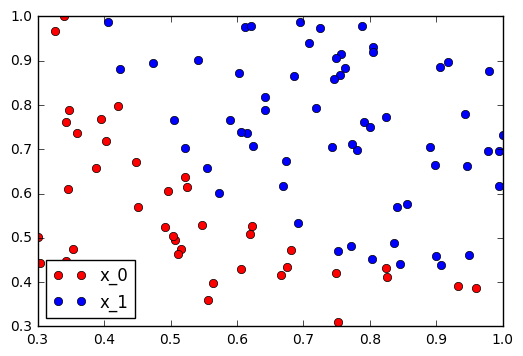

In [5]:
#读入数据
with open("./data.txt","r") as f:
    data_list=[i.split("\n")[0].split(",") for i in f.readlines()]
    data=[(float(i[0]),float(i[1]),float(i[2])) for i in data_list]
# 标准化
x0_max=max([i[0] for i in data])
x1_max=max([i[1] for i in data])
data=[(i[0]/x0_max, i[1]/x1_max,i[2]) for i in data]

x0=list(filter(lambda x:x[-1]==0.0,data)) # 选择第一类的点
x1=list(filter(lambda x:x[-1]==1.0,data)) # 选择第二类的点
plot_x0=[i[0] for i in x0]
plot_y0=[i[1] for i in x0]
plot_x1=[i[0] for i in x1]
plot_y1=[i[1] for i in x1]

plt.plot(plot_x0,plot_y0,"ro",label="x_0")
plt.plot(plot_x1,plot_y1,"bo",label="x_1")
plt.legend(loc="best")

In [6]:
# 将数据转为numpy，再转为tensor 
np_data=np.array(data,dtype="float32")
x_data=torch.from_numpy(np_data[:,0:2])
y_data=torch.from_numpy(np_data[:,-1]).unsqueeze(1)

In [7]:
#定义sigmoid 函数
def sigmoid(x):
    return 1/(1+np.exp(-x))

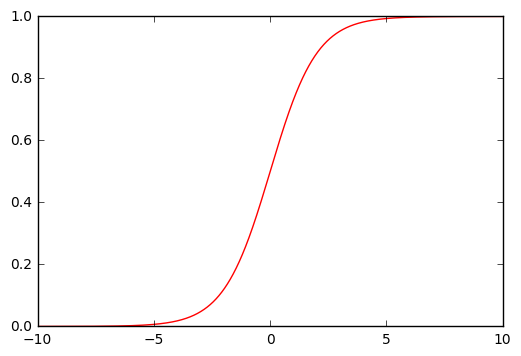

In [8]:
# 画出sigmoid 的图像
plot_x=np.arange(-10,10.01,0.01)
plot_y=sigmoid(plot_x)
plt.plot(plot_x,plot_y,"r")

In [9]:
x_data=Variable(x_data)
y_data=Variable(y_data)


In [19]:
# 可以直接通过导入torch.nn.functional 来使用
import torch.nn.functional as F
# 定义logistic 回归模型
w=Variable(torch.randn(2,1),requires_grad=True)
b=Variable(torch.zeros(1),requires_grad=True)

def logistic_regression(x):
    return F.sigmoid(torch.mm(x,w)+b)

16.30752
[0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33
 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42 0.43 0.44 0.45 0.46 0.47
 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61
 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75
 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89
 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99]


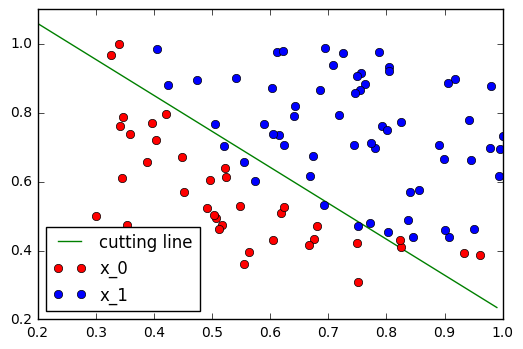

In [54]:
# 画出参数更新之前的结果
w0=w[0].data[0].numpy()
w1=w[1].data[0].numpy()
b0=b.data[0].numpy()

plot_x=np.arange(0.2,1,0.01)
print(w0)
print(plot_x)
plot_y=(- w0 * plot_x-b0)/w1

plt.plot(plot_x,plot_y,"g",label="cutting line")
plt.plot(plot_x0,plot_y0,"ro",label="x_0")
plt.plot(plot_x1,plot_y1,"bo",label="x_1")
plt.legend(loc="best")

In [24]:
# 计算loss
def binary_loss(y_pred,y):
    logits=(y*y_pred.clamp(1e-12).log()+(1-y)*(1-y_pred).clamp(1e-12).log()).mean()
    return -logits

# 查看一个log 函数的图像
y_pred=logistic_regression(x_data)
loss=binary_loss(y_pred,y_data)
print(loss)

tensor(0.6694, grad_fn=<NegBackward>)


C:\Users\cl\Anaconda3\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [25]:
# 得到loss 后，需要用梯度下降法更新参数
loss.backward()
w.data=w.data-0.1*w.grad.data
b.data=b.data-0.1*b.grad.data

# 算出一次更新之后的loss
y_pred=logistic_regression(x_data)
loss=binary_loss(y_pred,y_data)
print(loss)

tensor(0.6689, grad_fn=<NegBackward>)


C:\Users\cl\Anaconda3\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [26]:
# 上面的参数更新是繁琐的重复操作，如果我们的参数有100个，那么需要写100行来更新参数，为了方便，我们写了一个函数更新，
#就是 putorch 中的优化器，torch.optim
# 使用torch.optim 需要另外一个数据类型，就是nn.Parameter ，这个本质是和Variable 一样的，
#只不过nn.Parameter 默认是要求梯度的，而Variable 是默认不要求梯度的
#将参数w和b 放到torch.optim.SGD 中之后，说明一下学习率的大小，就可以使用optimizer.step()
# 来更新参数了

from torch import nn
w=nn.Parameter(torch.randn(2,1))
b=nn.Parameter(torch.zeros(1))

def logistic_regression(x):
    return F.sigmoid(torch.mm(x,w)+b)

optimizer=torch.optim.SGD([w,b],lr=1.)



In [55]:
import time
start=time.time()
# 使用自带的loss
criterion=nn.BCEWithLogitsLoss()
for e in range(1000):
    # 前向传播
    y_pred=logistic_regression(x_data)
    
    loss=binary_loss(y_pred,y_data)
    #loss=criterion(y_pred,y_data)
    # 反向传播
    optimizer.zero_grad() # 使用优化器梯度归0
    loss.backward()
    optimizer.step() # 使用优化器更新参数
    # 计算正确率
    mask=y_pred.ge(0.5).float()
#     print(y_pred)
#     print("y_pred")
#     print(mask)
#     print(float((mask==y_data).sum().data.numpy()/y_data.shape[0]))
    acc=float((mask==y_data).sum().data.numpy()/y_data.shape[0])
    if (e+1)%200==0:
        print(e+1,loss.data.numpy(),acc)
    during=time.time()-start
print(during)
    

C:\Users\cl\Anaconda3\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


200 0.20832095 0.89
400 0.20796433 0.89
600 0.2076387 0.89
800 0.20734084 0.89
1000 0.20706797 0.89
0.4968385696411133


In [ ]:
# 可以看到使用优化器后更新参数非常简单，只要在自动求导之前使用
#optimizer.zero_grad() 来归0 梯度，然后使用optimizer.step() 来更新参数就可以了

16.30752
15.623075
-19.810022


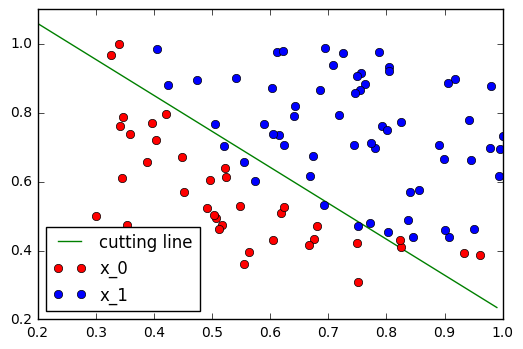

In [53]:
#画出更新后的结果
w0=w[0].data[0].numpy()
w1=w[1].data[0].numpy()
b0=b.data[0].numpy()

print(w0)
print(w1)
print(b0)
plot_x=np.arange(0.2,1,0.01)
plot_y=(-w0*plot_x-b0)/w1
plt.plot(plot_x,plot_y,"g",label="cutting line")
plt.plot(plot_x0,plot_y0,"ro",label="x_0")
plt.plot(plot_x1,plot_y1,"bo",label="x_1")
plt.legend(loc="best")

In [ ]:
#pytorch 之中的loss
# 线性回归的loss：nn.MSE()
#logistic 回归： nn.BCEWithLogitsLoss()
#能够提升速度

